In [2]:
import torch
import torch.nn as nn #neural network
import torch.optim as optim #optimize
from torch.utils.data import DataLoader, Dataset
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter #character count krne ke liye
import re #text saaf safai krne ke liye

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

Device in use: cuda


In [4]:
import re
from collections import Counter

class SimpleTokenizer:
    def __init__(self):
        self.vocab = {}
        self.idx_to_token = {}
        self.vocab_size = 0

    def build_vocab(self, texts, min_freq=2):
        # Character-level tokenization for Hindi
        all_chars = []
        for text in texts:
            # Keep Hindi characters (\u0900–\u097F), whitespace, and basic punctuation
            cleaned_text = re.sub(r'[^\u0900-\u097F\s.,!?।]', '', text)
            all_chars.extend(list(cleaned_text))

        # Count character frequency
        char_counts = Counter(all_chars)

        # Add special tokens
        self.vocab = {'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3}
        self.idx_to_token = {0: '<pad>', 1: '<unk>', 2: '<bos>', 3: '<eos>'}

        # Add frequent characters to vocabulary
        idx = 4
        for char, count in char_counts.most_common():
            if count >= min_freq:
                self.vocab[char] = idx
                self.idx_to_token[idx] = char
                idx += 1

        self.vocab_size = len(self.vocab)
        print(f"🔤 Hindi Vocabulary Size: {self.vocab_size}")

    def encode(self, text):
        tokens = [self.vocab['<bos>']]
        for char in text:
            tokens.append(self.vocab.get(char, self.vocab['<unk>']))
        tokens.append(self.vocab['<eos>'])
        return tokens

    def decode(self, token_ids):
      text = ""
      for token_id in token_ids:
          if token_id in [self.vocab['<pad>'], self.vocab['<bos>'], self.vocab['<eos>']]:
              continue
          elif token_id == self.vocab['<unk>']:
              text += "�"  # unknown character
          else:
              text += self.idx_to_token.get(token_id, "")  # don’t return � for missing keys
      return text

In [5]:
sample_texts_hi = [
    "आज मौसम बहुत अच्छा है।",
    "मैं स्कूल जा रहा हूँ।",
    "तुम क्या कर रहे हो?",
    "मुझे चाय पसंद है।",
    "यह किताब बहुत रोचक है।",
    "हम पार्क में खेलते हैं।",
    "कल मेरी परीक्षा है।",
    "माँ खाना बना रही हैं।",
    "सड़क पर बहुत ट्रैफिक है।",
    "मैं संगीत सुनना पसंद करता हूँ।",
    "तुम्हारा नाम क्या है?",
    "भारत एक सुंदर देश है।",
    "हमने फिल्म देखी।",
    "बिल्ली कुर्सी पर सो रही है।",
    "खिड़की से हवा आ रही है।",
    "पढ़ाई समय पर करनी चाहिए।",
    "पापा दफ्तर जा चुके हैं।",
    "छुट्टी के दिन मैं घूमने गया।",
    "बच्चे मैदान में दौड़ रहे हैं।",
    "आज रात को चाँदनी बहुत सुंदर है।"
]

In [6]:
tokenizer = SimpleTokenizer()
tokenizer.build_vocab(sample_texts_hi)

🔤 Hindi Vocabulary Size: 42


In [9]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []

        for text in texts:
            tokens = tokenizer.encode(text)
            if len(tokens) <= max_length:
                tokens += [tokenizer.vocab['<pad>']] * (max_length - len(tokens))
                self.data.append(tokens)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]
        input_ids = torch.tensor(tokens[:-1], dtype=torch.long)
        target_ids = torch.tensor(tokens[1:], dtype=torch.long)
        return input_ids, target_ids

In [10]:
dataset = TextDataset(sample_texts_hi, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()


        Q = self.w_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)


        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)


        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.w_o(context)

        return output

In [17]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [18]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

In [19]:
class SimpleLLM(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=8, n_layers=4, d_ff=512, max_length=64):
        super().__init__()
        self.d_model = d_model
        self.max_length = max_length


        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_length, d_model)


        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])


        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.size()


        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)


        token_emb = self.token_embedding(input_ids)
        pos_emb = self.position_embedding(positions)
        x = token_emb + pos_emb


        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0).to(input_ids.device)


        for block in self.transformer_blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.head(x)

        return logits

In [21]:
model = SimpleLLM(vocab_size=tokenizer.vocab_size, d_model=128, n_heads=8, n_layers=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.vocab['<pad>'])

In [22]:
print(f"{sum(p.numel() for p in model.parameters()):,}")

812,330


In [23]:
def train_model(model, dataloader, optimizer, criterion, epochs=50):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (input_ids, target_ids) in enumerate(dataloader):
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            optimizer.zero_grad()
            logits = model(input_ids)


            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses

In [24]:
losses = train_model(model, dataloader, optimizer, criterion, epochs=100)

Epoch 10/100, Loss: 0.6459
Epoch 20/100, Loss: 0.1813
Epoch 30/100, Loss: 0.1578
Epoch 40/100, Loss: 0.1512
Epoch 50/100, Loss: 0.1418
Epoch 60/100, Loss: 0.1436
Epoch 70/100, Loss: 0.1435
Epoch 80/100, Loss: 0.1397
Epoch 90/100, Loss: 0.1348
Epoch 100/100, Loss: 0.1331


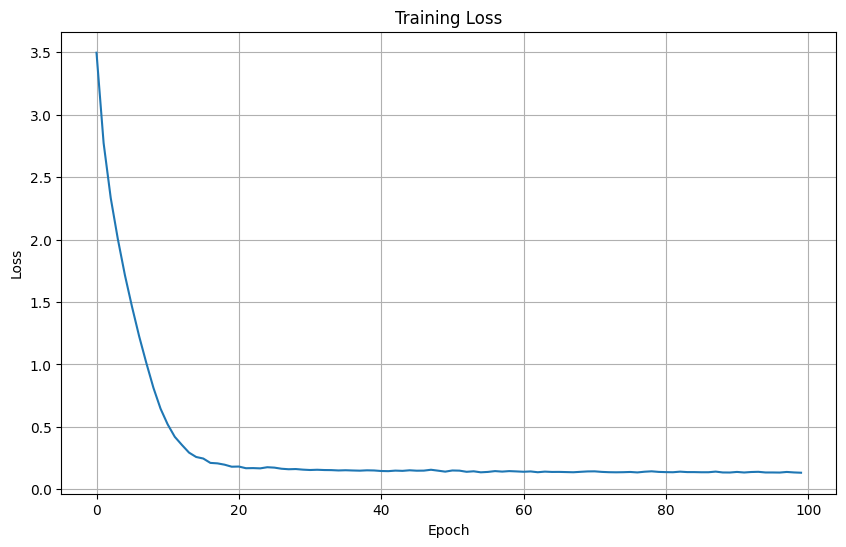

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [26]:
def generate_text(model, tokenizer, prompt="मैं", max_length=50, temperature=0.8):
    model.eval()
    device = next(model.parameters()).device  # Automatically detect model's device

    with torch.no_grad():
        # Encode prompt and move to device
        tokens = tokenizer.encode(prompt)
        input_ids = torch.tensor([tokens], dtype=torch.long).to(device)

        generated = tokens.copy()

        for _ in range(max_length):
            if input_ids.size(1) >= getattr(model, "max_length", 512):
                break

            # Forward pass
            logits = model(input_ids)
            next_token_logits = logits[0, -1, :] / temperature

            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probabilities, 1).item()

            if next_token == tokenizer.vocab['<eos>']:
                break

            generated.append(next_token)

            new_token = torch.tensor([[next_token]], dtype=torch.long).to(device)
            input_ids = torch.cat([input_ids, new_token], dim=1)

        return tokenizer.decode(generated)

In [27]:
text = generate_text(model, tokenizer, prompt="मैं स्कूल", max_length=60, temperature=0.9)
print("👉 Generated Hindi text:\n", text)

👉 Generated Hindi text:
 मैं स्कूल जा रना है।


In [28]:
print("\n=== हिंदी टेक्स्ट जनरेशन टेस्ट ===")

test_prompts = [
    "मैं",
    "आज",
    "खिड़की",
    "पढ़ाई",
    "बिल्ली"
]

for prompt in test_prompts:
    print(f"\nप्रॉम्प्ट: '{prompt}'")
    for i in range(3):
        generated_text = generate_text(model, tokenizer, prompt, max_length=30, temperature=0.8)
        print(f"  📝 जनरेशन {i+1}: {generated_text}")


=== हिंदी टेक्स्ट जनरेशन टेस्ट ===

प्रॉम्प्ट: 'मैं'
  📝 जनरेशन 1: मैंसंगीत सुनना पसंद करता हूँ।
  📝 जनरेशन 2: मैंसंगीत सुनना पसंद करता हूँ।
  📝 जनरेशन 3: मैंसंगीत सुनना पसंद करता हूँ।

प्रॉम्प्ट: 'आज'
  📝 जनरेशन 1: आजरात को चाँदनी बहुत सुंदर है।
  📝 जनरेशन 2: आजरात को चाँदनी बहुत सुंदर है।
  📝 जनरेशन 3: आजरात को चाँदनी बहुत सुंदर है।

प्रॉम्प्ट: 'खिड़की'
  📝 जनरेशन 1: खिड़कीसे ह�ा आ रही है।
  📝 जनरेशन 2: खिड़कीसे ह�ा आ रही है।
  📝 जनरेशन 3: खिड़कीसे ह�ा ै।

प्रॉम्प्ट: 'पढ़ाई'
  📝 जनरेशन 1: प�़ा� कुसुत करनी चाहिए।
  📝 जनरेशन 2: प�़ा�़के पर करनी चाहिए।
  📝 जनरेशन 3: प�़ा� के पर करनी चाहिए।

प्रॉम्प्ट: 'बिल्ली'
  📝 जनरेशन 1: बिल्लीकुर्सी पर सो रही है।
  📝 जनरेशन 2: बिल्लीकुर्सी पर सो रही है।
  📝 जनरेशन 3: बिल्लीकुर्सी पर सो रही है।


In [29]:
def analyze_attention(model, text, layer_idx=0):
    """अटेंशन वज़न का विज़ुअलाइज़ेशन"""
    model.eval()
    with torch.no_grad():
        tokens = tokenizer.encode(text)
        input_ids = torch.tensor([tokens], dtype=torch.long).to(device)

        # चुने गए लेयर का अटेंशन वज़न कैप्चर करने के लिए हुक
        attention_weights = None

        def hook_fn(module, input, output):
            nonlocal attention_weights
            # MultiHeadAttention की आंतरिक प्रक्रिया को कॉपी करते हैं
            x = input[0]
            batch_size, seq_len, d_model = x.size()
            Q = module.w_q(x).view(batch_size, seq_len, module.n_heads, module.d_k).transpose(1, 2)
            K = module.w_k(x).view(batch_size, seq_len, module.n_heads, module.d_k).transpose(1, 2)
            scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(module.d_k)
            attention_weights = torch.softmax(scores, dim=-1)

        # हुक को रजिस्टर करना
        hook = model.transformer_blocks[layer_idx].attention.register_forward_hook(hook_fn)

        # फॉरवर्ड पास रन करना
        _ = model(input_ids)

        # हुक हटाना
        hook.remove()

        if attention_weights is not None:
            # सभी हेड्स का एवरेज अटेंशन निकालना
            avg_attention = attention_weights[0].mean(dim=0).cpu().numpy()

            # टोकन टेक्स्ट तैयार करना विज़ुअलाइज़ेशन के लिए
            tokens_text = [tokenizer.idx_to_token.get(t, '?') for t in tokens]

            # विज़ुअलाइज़ेशन (Attention Heatmap)
            plt.figure(figsize=(10, 8))
            plt.imshow(avg_attention, cmap='Blues')
            plt.colorbar()
            plt.title(f'अटेंशन वज़न (लेयर {layer_idx})')
            plt.xlabel('की पोज़िशन')
            plt.ylabel('क्वेरी पोज़िशन')
            plt.xticks(range(len(tokens_text)), tokens_text, rotation=45)
            plt.yticks(range(len(tokens_text)), tokens_text)
            plt.tight_layout()
            plt.show()


=== अटेंशन मैकेनिज़्म का विज़ुअलाइज़ेशन ===


/tmp/ipython-input-29-2573987529.py:46: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-2573987529.py:46: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipython-input-29-2573987529.py:46: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-2573987529.py:46: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-2573987529.py:46: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-2573987529.py:46: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-2573987529.py:46: UserWarning: Glyph 2326 (\N{DEVANAGARI LETTER KHA}) missing from font(s) DejaVu Sans.
  

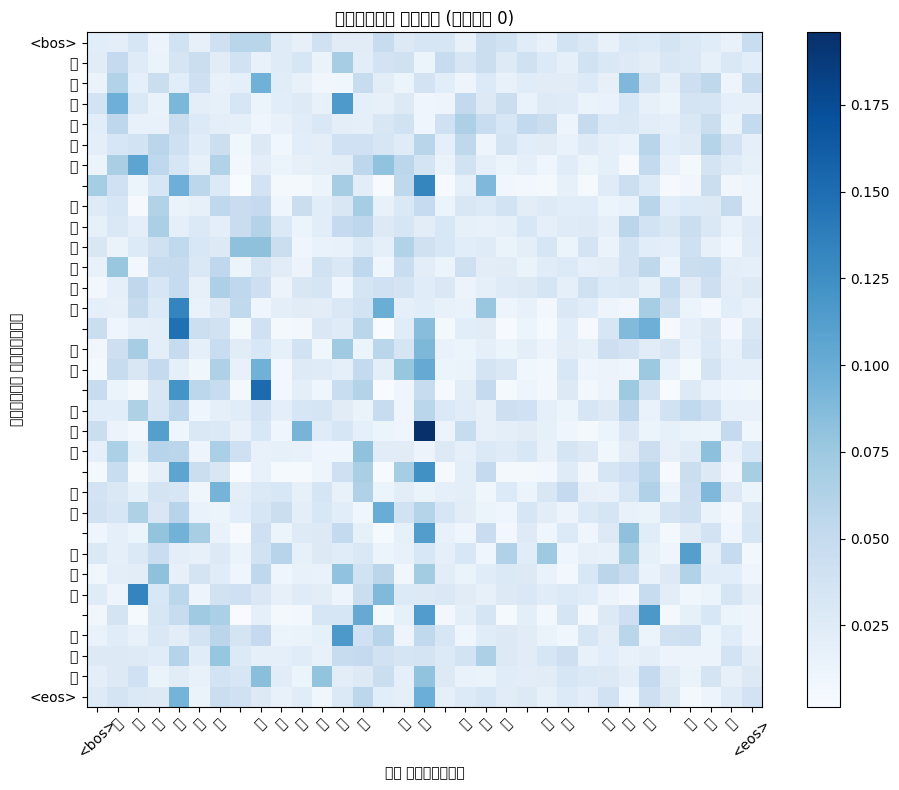


=== LLM निर्माण का अनुभव पूरा हुआ ===
इस कोड के माध्यम से आपने जो सीखा:
1. हिंदी टेक्स्ट टोकनाइज़ेशन
2. Transformer आर्किटेक्चर का इम्प्लीमेंटेशन
3. लैंग्वेज मॉडल की ट्रेनिंग
4. टेक्स्ट जनरेशन
5. अटेंशन वज़न का विज़ुअलाइज़ेशन

और बेहतर मॉडल और परिणामों के लिए अधिक डेटा और कंप्यूटिंग संसाधन की आवश्यकता होगी।


In [30]:
# अटेंशन मैकेनिज़्म का विज़ुअलाइज़ेशन
print("\n=== अटेंशन मैकेनिज़्म का विज़ुअलाइज़ेशन ===")
analyze_attention(model, "बिल्ली खिड़की के पास सो रही है।", layer_idx=0)

print("\n=== LLM निर्माण का अनुभव पूरा हुआ ===")
print("इस कोड के माध्यम से आपने जो सीखा:")
print("1. हिंदी टेक्स्ट टोकनाइज़ेशन")
print("2. Transformer आर्किटेक्चर का इम्प्लीमेंटेशन")
print("3. लैंग्वेज मॉडल की ट्रेनिंग")
print("4. टेक्स्ट जनरेशन")
print("5. अटेंशन वज़न का विज़ुअलाइज़ेशन")
print("\nऔर बेहतर मॉडल और परिणामों के लिए अधिक डेटा और कंप्यूटिंग संसाधन की आवश्यकता होगी।")